In [1]:
#TF-IDF, SVM을 사용한다. 
#tokenize: use split()

In [2]:
import numpy as np 
import pandas as pd
import nltk
import itertools
import pickle

def read_files(data_dir, type_):
    train = pd.read_csv(data_dir+type_+'train.tsv', sep='\t')
    dev = pd.read_csv(data_dir+type_+'dev.tsv', sep='\t')
    test = pd.read_csv(data_dir+type_+'test.tsv', sep='\t')
    return train, dev, test

In [3]:
def build_vocab(train, dev, data_dir, type_):
    
    # Hyper parameters
    WORD_CUT_OFF = 0
    
    append_td = train.append(dev)
    #itertools.chain: list들 연결 
    tokenized_sents = [sent.split() for sent in append_td['text']]

    # Count the word frequencies
    word_freq = nltk.FreqDist(itertools.chain(*tokenized_sents))
    print("%d unique words found" % len(word_freq.items()))

    # Cut-off
    # 단어 빈도수가 WORD_CUT_OFF(hyper parameter)보다 큰 것만 추출 
    retained_words = [w for (w, f) in word_freq.items() if f > WORD_CUT_OFF]
    print("%d words retained" % len(retained_words))

    # Get the most common words and build index_to_word and word_to_index vectors
    # Word index starts from 2, 1 is reserved for UNK, 0 is reserved for padding
    word_to_index = {'PAD': 0, 'UNK': 1}
    for i, w in enumerate(retained_words):
        word_to_index[w] = i + 2
        index_to_word = {i: w for (w, i) in word_to_index.items()}

    print("Vocabulary size = %d" % len(word_to_index))

    with open('{}w2i.pkl'.format(data_dir+type_), 'wb') as f:
        pickle.dump(word_to_index, f)

    with open('{}i2w.pkl'.format(data_dir+type_), 'wb') as f:
        pickle.dump(index_to_word, f)
    
    return word_to_index

In [4]:
from tqdm import tqdm
def wordDict(sentence, word_to_index):
    wordDict = dict.fromkeys(word_to_index.keys(),0)
    for word in sentence.split():
        find_word = word_to_index.get(word, 0)
        if find_word:
            wordDict[word]+=1
        else:
            wordDict['UNK']+=1 #UNK TOKEN
    return wordDict

def computeWB(data, word_to_index):
    wordBoard = pd.DataFrame()
    for index, s in enumerate(data):
        newDict = wordDict(s, word_to_index)
        wordBoard = wordBoard.append(newDict, ignore_index = True)
    return wordBoard

#tf = (Frequency of the word in the document) / (Total number of words in the document)
def computetfBoard(wordBoard, data):
    tfBoard = wordBoard.copy()
    for i in range(tfBoard.shape[0]):
        for j in range(tfBoard.shape[1]):
            if tfBoard.iloc[i,j]>0:
                sentence = data.iloc[i]
                tfBoard.iloc[i,j] /= float(len(sentence.split()))
    return tfBoard

#idf (Total number of (documents))/(Number of (documents) containing the word)
import math 

def computeIDF(wordBoard, word_to_index):
    N = wordBoard.shape[0]
    idfDict = dict.fromkeys(word_to_index.keys(),0)
    
    for i in range(wordBoard.shape[0]):
        for j in range(wordBoard.shape[1]):
                if wordBoard.iloc[i,j]>0:
                    word = wordBoard.columns[j]
                    idfDict[word] +=1
    for word, val in idfDict.items():
        if val>0:
            idfDict[word] = math.log10(N/float(val))
    return idfDict

#tf-idf
def computeTFIDF(tfBoard, idfs):
    tfidfBoard = tfBoard.copy()
    for i in range(tfidfBoard.shape[0]):
        for j in range(tfidfBoard.shape[1]):
            word = tfidfBoard.columns[j]
            if(tfidfBoard.iloc[i,j]==0 or idfs[word]==0): continue
            else : tfidfBoard.iloc[i,j] *=idfs[word]
    return tfidfBoard
    

In [5]:
def get_tfidf_table(train, dev, test, word_to_index):
    train_wordBoard = computeWB(train['text'], word_to_index)
    dev_wordBoard = computeWB(dev['text'], word_to_index)
    test_wordBoard = computeWB(test['text'], word_to_index)
    print("set wordBoard: Done.")
#     print("-----------------train word Board-------------------")
#     print(train_wordBoard)
    
    train_tfBoard = computetfBoard(train_wordBoard, train['text'])
    dev_tfBoard = computetfBoard(dev_wordBoard, dev['text'])
    test_tfBoard = computetfBoard(test_wordBoard, test['text'])
    print("set tfBoard: Done.")
#     print("-----------------train tf Board-------------------")
#     print(train_tfBoard)
    
    wordBoard = train_wordBoard.append(dev_wordBoard)
    idf = computeIDF(wordBoard, word_to_index)
    print("set idf: Done.")
#     print("-----------------train idf-------------------")
#     print(idf)
    
    train_tfidf = computeTFIDF(train_tfBoard, idf)
    dev_tfidf = computeTFIDF(dev_tfBoard, idf)
    test_tfidf = computeTFIDF(test_tfBoard, idf)
    print("set tfidf: Done.")
#     print("-----------------train tfidf Board-------------------")
#     print(train_tfidf)
  
    return train_tfidf, dev_tfidf, test_tfidf

In [6]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt

#svm 학습 모델 함수 
def svm_func(k, x_train, y_train, x_val, y_val):
    c = [0.001, 0.01, 0.1, 10, 25, 50, 100, 1000]
    train_scores=[]
    valid_scores=[]
    
    svm=SVC(gamma='auto',random_state=101)
    svm.kernel = k
    
    for i in c:
        svm.C = i
        svm.fit(x_train, y_train)
        
        train_score=svm.score(x_train, y_train)
        train_scores.append(train_score)
        
        valid_score=svm.score(x_val,y_val)
        valid_scores.append(valid_score)
        
    return train_scores, valid_scores, svm

def svm_visual(title, title2, t_s, v_s):
    c=['0.001', '0.01', '0.1', '10', '25', '50', '100', '1000']
    plt.plot(c, t_s, color='orange', marker='o', label='Training Accuracy')
    plt.plot(c, v_s, color='pink', marker='o', label='Validation Accuracy')
    plt.xticks(c)
    plt.legend()
    plt.title(title)
    plt.xlabel('Value of C')
    plt.ylabel('Accuracy Score')
    plt.ylim(0.2, 1.3)
    plt.savefig(title+'tfidf '+title2+'.png', bbox_inches='tight')
    plt.show()
    

In [7]:
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sn

def validation(title,train_tfidf, train, dev_tfidf, dev):
    print("Start validation...")
    t_s, v_s, svm1 = svm_func('rbf', train_tfidf, train['label']
                              , dev_tfidf, dev['label'])
    svm_visual(title,'Kernel = rbf', t_s, v_s)
    t_s2, v_s2, svm2 = svm_func("linear", train_tfidf, train['label']
                              , dev_tfidf, dev['label'])
    svm_visual(title,'Kernel = linear', t_s2, v_s2)
    t_s3, v_s3, svm3 = svm_func("sigmoid", train_tfidf, train['label']
                              , dev_tfidf, dev['label'])
    svm_visual(title,'Kernel = sigmoid', t_s3, v_s3)
    
    return [svm1, svm2, svm3]
    
def test_result(title, train_tfidf, train, test_tfidf, test, svm, C):
    #linear
    svm.C=C
    svm.fit(train_tfidf, train['label'])
    y_pred = svm.predict(test_tfidf)
    target_names=['0', '1', '2']
    print("Accuracy:", metrics.accuracy_score(test['label'], y_pred))
    print(classification_report(test['label'], y_pred, target_names=target_names))
    
    data_= {'y_Actual': test['label'], 'y_Predicted': y_pred}
    df_cm = pd.DataFrame(data_, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df_cm['y_Actual'], df_cm['y_Predicted'],
                               rownames=['Actual'], colnames=['Predicted'])

    sn.heatmap(confusion_matrix, annot=True)
    plt.savefig(title+'cm.png', box_inches='tight')
    plt.show()


In [8]:
def main(data_dir, result_dir, type_):
    train, dev, test = read_files(data_dir, type_)
    print("train sample: ", train.shape[0])

    word_to_index = build_vocab(train, dev, data_dir, type_)
    train_tfidf, dev_tfidf, test_tfidf = get_tfidf_table(train, dev, test, word_to_index)
    
    title = result_dir+type_
    svm = validation(title, train_tfidf, train, dev_tfidf, dev)
    return [title, train_tfidf, train, test_tfidf, test, svm]

In [9]:
data_dir = "../data/"
result_dir = "./tfidf_result/"
type_ = ['uneven-even/', 'even-even/', 'upeven-even/']

train sample:  1196
1525 unique words found
1525 words retained
Vocabulary size = 1527
set wordBoard: Done.
set tfBoard: Done.
set idf: Done.
set tfidf: Done.
Start validation...


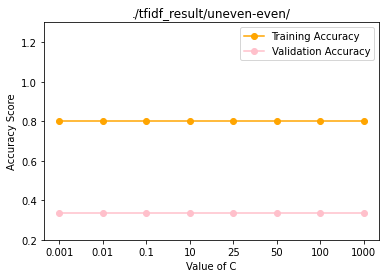

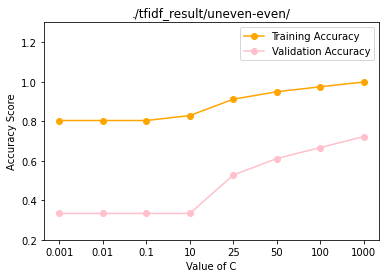

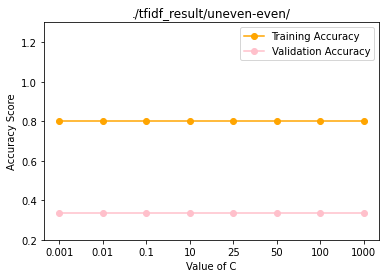

In [10]:
test_list = main(data_dir,result_dir,type_[0])

Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.55      0.96      0.70        25
           1       0.81      0.52      0.63        25
           2       0.87      0.52      0.65        25

    accuracy                           0.67        75
   macro avg       0.74      0.67      0.66        75
weighted avg       0.74      0.67      0.66        75



/home/yoonjin/anaconda3/envs/medinfo/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later


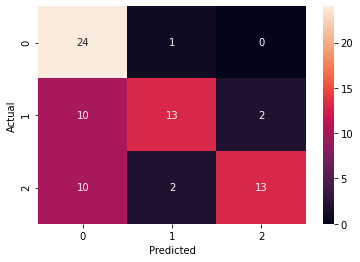

In [11]:
test_result(test_list[0],test_list[1],test_list[2],test_list[3],test_list[4],test_list[5][1], 1000)

train sample:  270
992 unique words found
992 words retained
Vocabulary size = 994
set wordBoard: Done.
set tfBoard: Done.
set idf: Done.
set tfidf: Done.
Start validation...


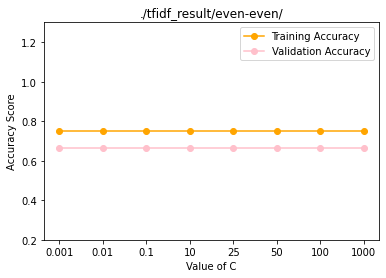

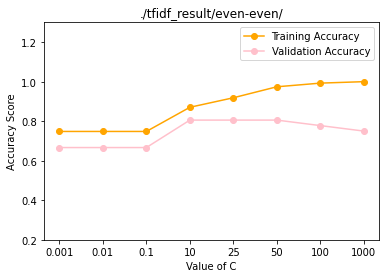

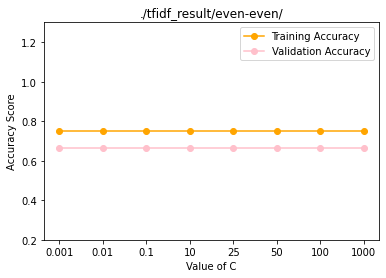

In [12]:
test_list = main(data_dir,result_dir,type_[1])

Accuracy: 0.6533333333333333
              precision    recall  f1-score   support

           0       0.73      0.76      0.75        25
           1       0.55      0.48      0.51        25
           2       0.67      0.72      0.69        25

    accuracy                           0.65        75
   macro avg       0.65      0.65      0.65        75
weighted avg       0.65      0.65      0.65        75



/home/yoonjin/anaconda3/envs/medinfo/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later


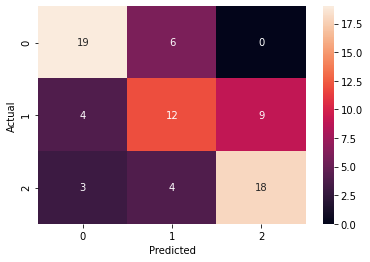

In [14]:
test_result(test_list[0],test_list[1],test_list[2],test_list[3],test_list[4],test_list[5][1], 1000)

train sample:  435
1089 unique words found
1089 words retained
Vocabulary size = 1091
set wordBoard: Done.
set tfBoard: Done.
set idf: Done.
set tfidf: Done.
Start validation...


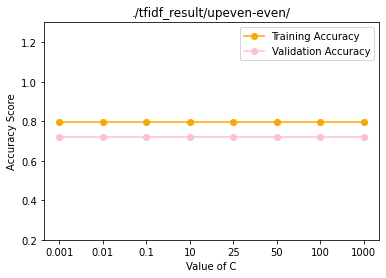

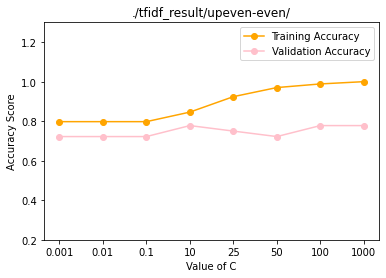

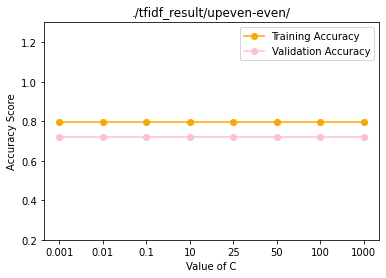

In [15]:
test_list = main(data_dir,result_dir,type_[2])

Accuracy: 0.7466666666666667
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        25
           1       0.68      0.76      0.72        25
           2       0.82      0.72      0.77        25

    accuracy                           0.75        75
   macro avg       0.75      0.75      0.75        75
weighted avg       0.75      0.75      0.75        75



/home/yoonjin/anaconda3/envs/medinfo/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later


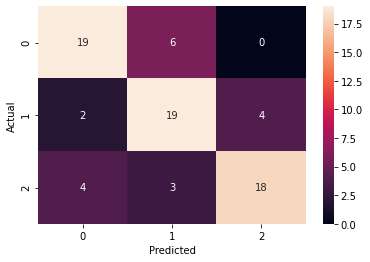

In [17]:
test_result(test_list[0],test_list[1],test_list[2],test_list[3],test_list[4],test_list[5][1], 1000)